In [2]:
import os
import zipfile

In [ ]:
base_dir = './tmp/people_face_picture'
man_dir = os.path.join(base_dir, 'man')
woman_dir = os.path.join(base_dir, 'woman')

if()
train_dir = os.path.makedirs('train')
validation_dir = os.path.makedirs('validation')


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2, # 最多移動 total width * 0.2
      height_shift_range=0.2, # 最多移動 total height * 0.2
      shear_range=0.2, # 平移
      zoom_range=0.2,
      horizontal_flip=True, # 左右顛倒
      fill_mode='nearest') # 移動後填滿原本的位置

In [4]:
base_dir = './tmp/people_face_picture'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with real face pictures
train_man_dir = os.path.join(train_dir, 'man')

# Directory with anime face pictures
train_woman_dir = os.path.join(train_dir, 'woman')

# Directory with real face pictures
validation_man_dir = os.path.join(validation_dir, 'man')

# Directory with anime face pictures
validation_woman_dir = os.path.join(validation_dir, 'woman')

train_man_fnames = os.listdir(train_man_dir)
train_woman_fnames = os.listdir(train_woman_dir)
validation_man_fnames = os.listdir(validation_man_dir)
validation_woman_fnames = os.listdir(validation_woman_dir)

train_man_fnames.sort()
train_woman_fnames.sort()
validation_man_fnames.sort()
validation_woman_fnames.sort()

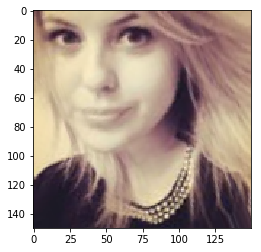

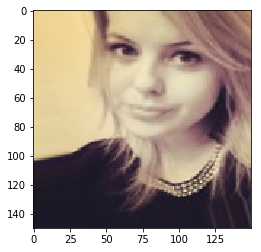

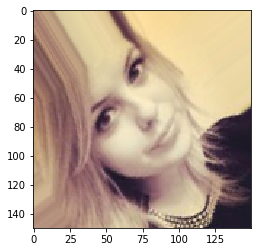

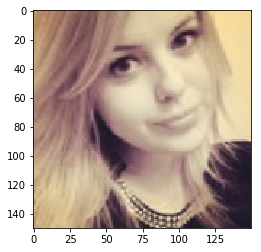

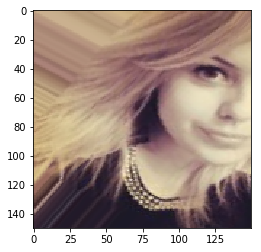

In [72]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_woman_dir, random.choice(train_woman_fnames))
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# The .flow() command below generates batches of randomly transformed images
# It will loop indefinitely, so we need to `break` the loop at some point!
# run 5 times
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(array_to_img(batch[0]))
    i += 1
    if i % 5 == 0:
        break
    

<h1>Define training model</h1>
<p>Define CNN model with 3 convs, output layer is 1.
    </p>

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Convolution2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
__________

<h1>Data Preprocessing</h1>
<p>Let training and validation images be in [0, 1] range, and augmented training images.

</p>

In [10]:


# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 32 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 1292 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


<h1><b>Run model:</b></h1>

In [12]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=70,  # 1292 images = batch_size(20) * steps(70)
      epochs=100,
      validation_data=validation_generator,
      validation_steps=6,  # 120 images = batch_size(20) * steps(6)
      verbose=2) # >1, show all training process

Epoch 1/100
 - 59s - loss: 0.6795 - acc: 0.6052 - val_loss: 0.6460 - val_acc: 0.6500
Epoch 2/100
 - 67s - loss: 0.6473 - acc: 0.6274 - val_loss: 0.6044 - val_acc: 0.6500
Epoch 3/100
 - 64s - loss: 0.6432 - acc: 0.6672 - val_loss: 0.6160 - val_acc: 0.6500
Epoch 4/100
 - 60s - loss: 0.6453 - acc: 0.6398 - val_loss: 0.5823 - val_acc: 0.7333
Epoch 5/100
 - 60s - loss: 0.6413 - acc: 0.6283 - val_loss: 0.5621 - val_acc: 0.7333
Epoch 6/100
 - 58s - loss: 0.6257 - acc: 0.6650 - val_loss: 0.5664 - val_acc: 0.7417
Epoch 7/100
 - 60s - loss: 0.6052 - acc: 0.6879 - val_loss: 0.6967 - val_acc: 0.6417
Epoch 8/100
 - 56s - loss: 0.6219 - acc: 0.6812 - val_loss: 0.5516 - val_acc: 0.6583
Epoch 9/100
 - 61s - loss: 0.6075 - acc: 0.6864 - val_loss: 1.0843 - val_acc: 0.5250
Epoch 10/100
 - 56s - loss: 0.6079 - acc: 0.6738 - val_loss: 0.5040 - val_acc: 0.7500
Epoch 11/100
 - 59s - loss: 0.5873 - acc: 0.6912 - val_loss: 0.6111 - val_acc: 0.6667
Epoch 12/100
 - 59s - loss: 0.6179 - acc: 0.6984 - val_loss: 0.

Epoch 97/100
 - 57s - loss: 0.4902 - acc: 0.7864 - val_loss: 0.3868 - val_acc: 0.8333
Epoch 98/100
 - 55s - loss: 0.4779 - acc: 0.7824 - val_loss: 0.4211 - val_acc: 0.8000
Epoch 99/100
 - 56s - loss: 0.4559 - acc: 0.7888 - val_loss: 0.5144 - val_acc: 0.7750
Epoch 100/100
 - 55s - loss: 0.4857 - acc: 0.7848 - val_loss: 0.4257 - val_acc: 0.7917


<h1>Visualizing Intermediate Representations</h1>
<p>定義新的model，可將model的中間過程視覺化，看每一層的output images
    </p>

C:\Users\deoxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
C:\Users\deoxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide


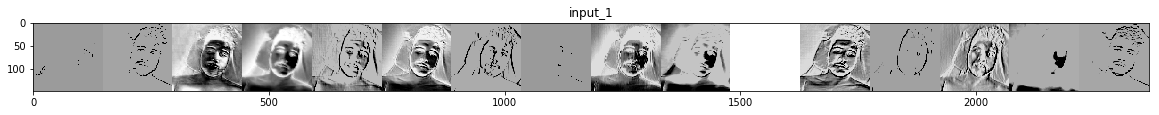

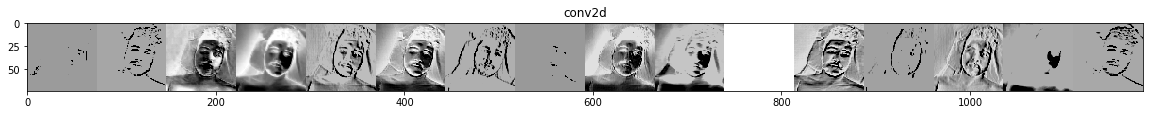

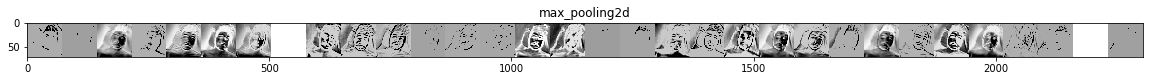

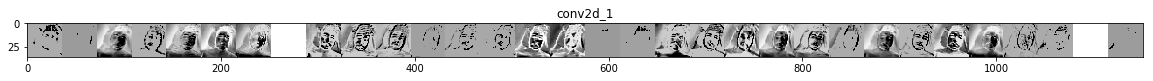

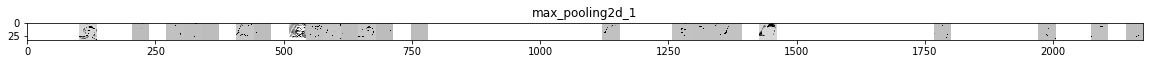

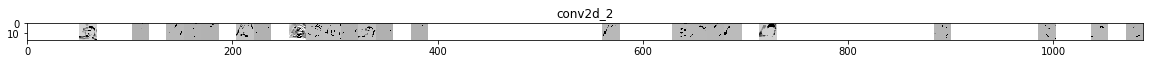

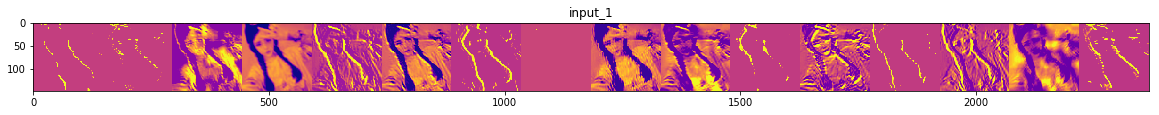

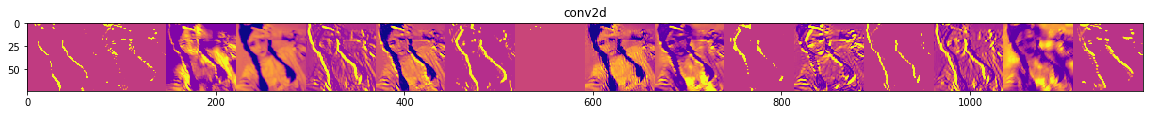

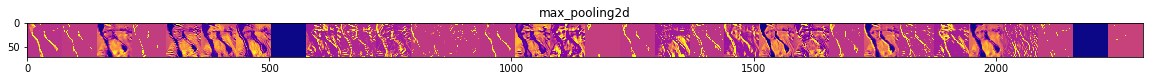

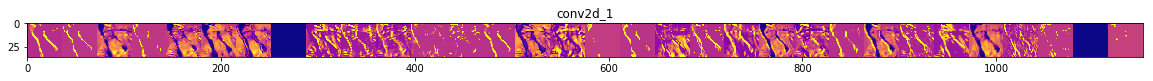

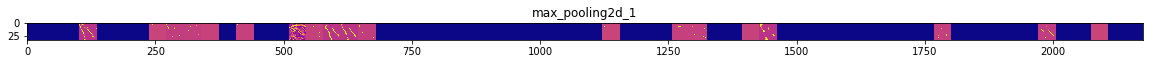

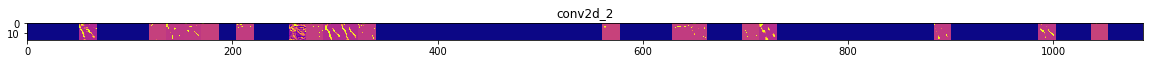

In [108]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image from the training set.
man_img_files = [os.path.join(train_man_dir, f) for f in train_man_fnames]
img_path = random.choice(man_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so we can let them be the title of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # number of features in feature map
        # The feature map has shape (1, size, size, n_features)
        size = feature_map.shape[1]
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            # Postprocess the feature to make it visually palatable
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255)
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='Greys')
    
    
    
    
woman_img_files = [os.path.join(train_woman_dir, f) for f in train_woman_fnames]
img_path = random.choice(woman_img_files)
img = load_img(img_path, target_size=(150, 150))
y = img_to_array(img)
y = y.reshape((1,) + y.shape)
y /= 255


successive_feature_maps = visualization_model.predict(y)
layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
#     if layer_name == 'conv2d' or layer_name == 'conv2d_1' or layer_name == 'conv2d_2':
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        for i in range(n_features):
            
            # Postprocess the feature to make it visually palatable
            y = feature_map[0, :, :, i]
            y -= y.mean()
            y /= y.std()
            y *= 64
            y += 128
            y = np.clip(y, 0, 255).astype('uint8')
            # We'll tile each filter into this big horizontal grid
            display_grid[:, i * size : (i + 1) * size] = y
        
        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='plasma')

Text(0.5, 1.0, 'Training(r) and validation(b) loss in 100 epochs')

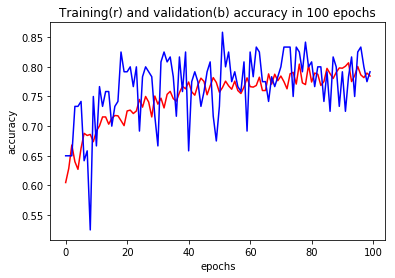

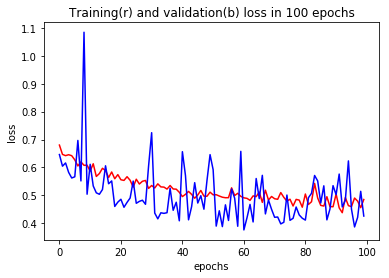

In [66]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))




# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title('Training(r) and validation(b) accuracy in 100 epochs')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('Training(r) and validation(b) loss in 100 epochs')


In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)